# CS 109A - Intro to Data Science: Project (WIP)
## Predicting Loan Outcomes
## Group: Andrew Greene and David Modjeska
### Harvard University, Fall 2016

In [7]:
import itertools as it
import matplotlib
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import sklearn.preprocessing as Preprocessing
import datetime

from itertools import combinations
from sklearn.cross_validation import KFold as kfold
from sklearn.decomposition import TruncatedSVD as tSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import AdaBoostClassifier as Boost
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import LogisticRegression as Log_Reg
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from scipy.io import mmread

%matplotlib inline
plt.style.use('ggplot') 
from IPython.display import display, HTML

In [8]:
### specify dataset proportion to work with

# load and clean full dataset?
load_full = False

# if not loading and cleaning full dataset, what sample percentage?
sample_percent = 10

if load_full:
    pct_str = ""
else: # not load_full
    pct_str = str(sample_percent) + "_pct"

### set intermediate file names

processed_data_train_file = "./intermediate_files/processed_data_train" + pct_str + ".json"
processed_data_test_file = "./intermediate_files/processed_data_test" + pct_str + ".json"

nlp_data_train_file = "./intermediate_files/nlp_data_train" + pct_str + ".json"
nlp_data_test_file = "./intermediate_files/nlp_data_test" + pct_str + ".json"

term_freqs_train_file = "./intermediate_files/term_freqs_train" + pct_str + ".mtx"
term_freqs_test_file = "./intermediate_files/term_freqs_test" + pct_str + ".mtx"

diff_terms_train_file = "./intermediate_files/diff_terms_train" + pct_str + ".json"
diff_terms_test_file = "./intermediate_files/diff_terms_test" + pct_str + ".json"


In [9]:
### load processed data
data = pd.read_json(processed_data_train_file)
data_nlp = pd.read_json(nlp_data_train_file)
desc_matrix_coo = mmread(term_freqs_train_file)
desc_matrix = sp.sparse.csr_matrix(desc_matrix_coo)
count_cols_df = pd.read_json(diff_terms_train_file)

count_cols_bool = count_cols_df.values > 0.0

## Step 2: Explore Data

In [10]:
image_counter = 0

In [11]:
def good_bad_quantile_plot(data, column):
    global image_counter
    
    col_data = data[column]
    nulls = pd.isnull(col_data)
    col_data = col_data[~nulls]
    #if col_data.dtype == '<M8[ns]':
    #    col_data = col_data.dt.strftime('%Y-%m')
    
    defaults = data['loan_status'] == True  # for now TODO

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # 45-degree line
    ax.plot(
        [min(col_data), max(col_data)],
        [min(col_data), max(col_data)],
        c='k'
    )
    # Actual qq plot
    ax.plot(
        list(col_data[~defaults].quantile(q=np.arange(0.0, 1.005, .005))),
        list(col_data[defaults].quantile(q=np.arange(0.0, 1.0005, .005))),
        c='r'
    )
    ax.scatter(
        list(col_data[~defaults].quantile(q=np.arange(0.0, 1.1, .1))),
        list(col_data[defaults].quantile(q=np.arange(0.0, 1.1, .1))),
        c='r'
    )
    
    ax.set_title("QQ plot for " + column)
    ax.set_xlabel('Good loans')
    ax.set_ylabel('Bad loans')
    
    plt.show()
    
    fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
    image_counter += 1

In [12]:
# print dataset shape, and widen pandas dataframe display
n, p = data.shape
pd.set_option('display.max_columns', p)

print
print "The shape of the data is", data.shape
print


The shape of the data is (173709, 26)



In [13]:
# display top rows of data set
print
data.head()

,Unnamed: 0,annual_income,cpi,delinq_2_yrs,desc_len,description,dti,earliest_credit,employ_length,gdp,home_owner,index,inquiry_6_mos,ipr,issue_date,level_0,loan_amount,loan_purpose,loan_status,loan_subgrade,loan_term,open_accounts,revol_util,rir,total_accounts,unemploy
1,1,30000.0,0.021897,0,626.0,Borrower added on _number_/_number_/_number_...,0.000161,1999-04-01,0,0.999758,RENT,1,3,0.000004,Dec-2011,1,2500,car,True,12,60,3,0.001511,0.000108,4,0.001093
10,10,30000.0,0.021895,0,388.0,Borrower added on _number_/_number_/_number_...,0.001620,2004-04-01,0,0.999649,RENT,12,1,0.000020,Dec-2011,10,9000,debt_consolidation,True,12,36,4,0.014741,0.000672,9,0.001093
100,100,30000.0,0.021895,0,244.0,Borrower added on _number_/_number_/_number_...,0.003170,1995-07-01,10,0.999666,MORTGAGE,109,1,0.000005,Dec-2011,100,2100,vacation,False,7,36,12,0.013327,0.000783,26,0.001093
1000,1000,53000.0,0.021895,0,167.0,Borrower added on _number_/_number_/_number_...,0.003381,1994-07-01,9,0.999661,RENT,1108,2,0.000014,Dec-2011,1000,17000,debt_consolidation,True,12,60,7,0.013600,0.000234,12,0.001093
10000,10003,115000.0,0.021984,0,230.0,Borrower added on _number_/_number_/_number_...,0.001279,1993-08-01,2,0.999698,MORTGAGE,11090,0,0.000010,Jul-2011,10000,18000,debt_consolidation,False,7,36,9,0.010854,0.000606,17,0.001090


In [14]:
# summarize data set
print
data.describe()

/Users/davidmodjeska/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Unnamed: 0,annual_income,cpi,delinq_2_yrs,desc_len,dti,gdp,index,inquiry_6_mos,ipr,level_0,loan_amount,loan_subgrade,loan_term,open_accounts,revol_util,rir,total_accounts,unemploy
count,173709.000000,1.737090e+05,173709.000000,173709.000000,61407.000000,173709.000000,173709.000000,173709.000000,173709.000000,1.737090e+05,173709.000000,173709.000000,173709.000000,173709.000000,173709.000000,173709.000000,173709.000000,173709.000000,173709.000000
mean,8123.047677,7.234698e+04,0.020923,0.210242,291.780644,0.002417,0.999738,247435.052375,0.820786,1.146465e-05,8116.794444,13533.356648,11.159013,41.307083,10.917224,0.008000,0.000392,24.993293,0.000973
std,6578.722797,5.792260e+04,0.000697,0.514894,314.126188,0.001118,0.000041,213227.357990,0.969264,6.042850e-06,6573.955604,8101.970424,6.755006,9.960192,4.856033,0.003727,0.000331,11.709388,0.000132
min,0.000000,3.000000e+03,0.019594,0.000000,1.000000,0.000000,0.992349,1.000000,0.000000,4.790000e-08,0.000000,500.000000,1.000000,36.000000,1.000000,0.000000,0.000000,2.000000,0.000705
25%,2749.000000,4.500000e+04,0.020243,0.000000,NaN,0.001580,0.999715,96147.000000,0.000000,6.841300e-06,2747.000000,7200.000000,6.000000,36.000000,7.000000,0.005276,0.000174,16.000000,0.000880
50%,6457.000000,6.200000e+04,0.020924,0.000000,NaN,0.002373,0.999744,194540.000000,1.000000,1.060700e-05,6451.000000,12000.000000,11.000000,36.000000,10.000000,0.008139,0.000321,23.000000,0.000977
75%,12130.000000,8.662300e+04,0.021466,0.000000,NaN,0.003227,0.999765,352584.000000,1.000000,1.535900e-05,12119.000000,18200.000000,16.000000,36.000000,13.000000,0.010832,0.000525,32.000000,0.001082
max,27517.000000,8.706582e+06,0.023216,2.000000,5016.000000,0.005802,0.999807,887364.000000,3.000000,6.533500e-05,27493.000000,35000.000000,34.000000,60.000000,76.000000,0.121802,0.016245,150.000000,0.001244


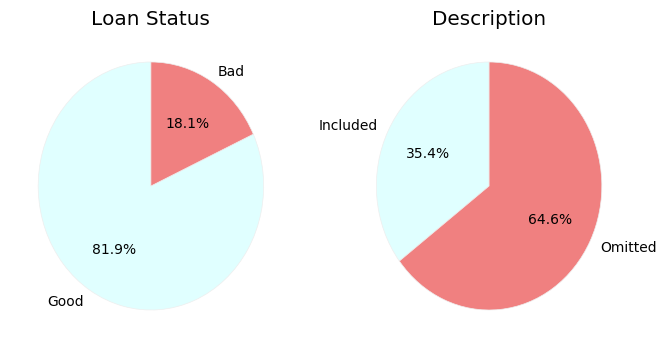

In [15]:
### plot description-related variables as pie charts
n, p = data.shape
fig = plt.figure(figsize = (8, 4))

# loan status
num_good = (data["loan_status"] == False).sum()
num_bad = n - num_good
pie_1 = fig.add_subplot(121)
pie_1.pie([num_good, num_bad], 
          labels = ["Good", "Bad"],
          colors = ["lightcyan", "lightcoral"],
         autopct = "%1.1f%%", startangle = 90)
pie_1.set_title("Loan Status")

# description included
num_include = (data["description"].notnull()).sum()
num_omit = n - num_include
pie_3 = fig.add_subplot(122)
pie_3.pie([num_include, num_omit], 
          labels = ["Included", "Omitted"],
          colors = ["lightcyan", "lightcoral"],
         autopct = "%1.1f%%", startangle = 90)
pie_3.set_title("Description")

plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

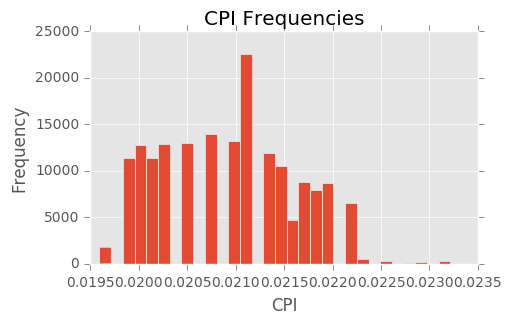

In [16]:
# plot histogram of CPI
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data['cpi'], bins = 30)
ax.set_title("CPI Frequencies")
ax.set_xlabel("CPI")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

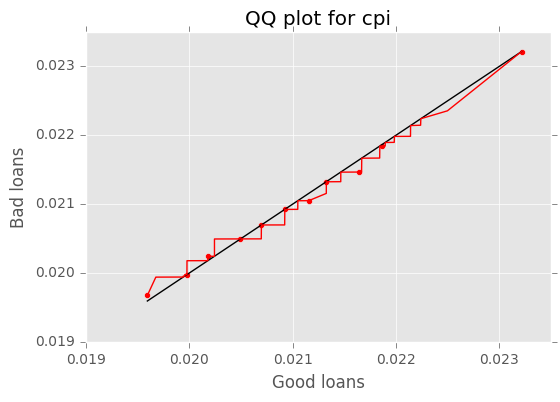

In [17]:
good_bad_quantile_plot(data, 'cpi')

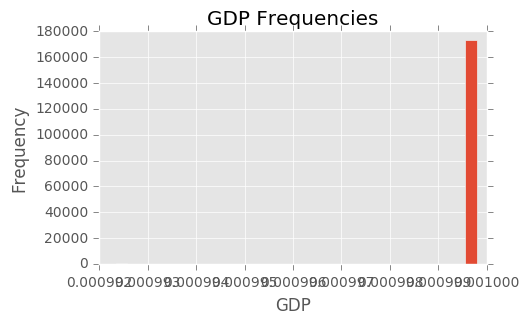

In [18]:
# plot histogram of GDP
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data['gdp'] / 1000.0, bins = 30)
ax.set_title("GDP Frequencies")
ax.set_xlabel("GDP")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

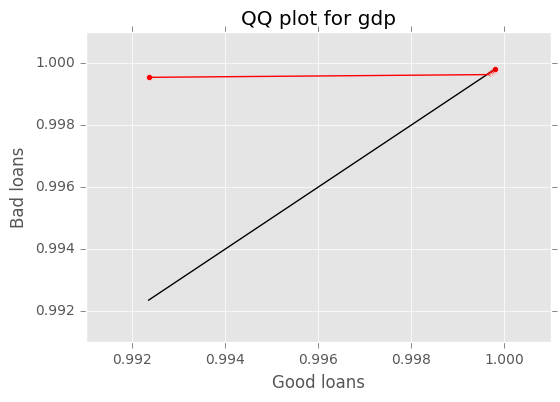

In [19]:
good_bad_quantile_plot(data, 'gdp')

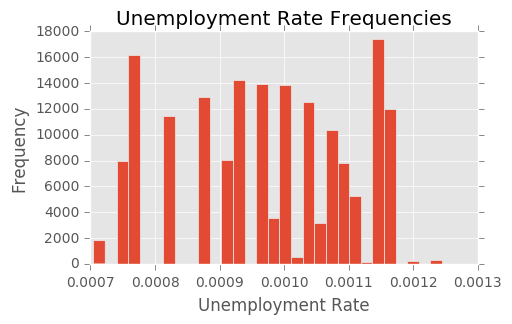

In [20]:
# plot histogram of unemployment rate
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data['unemploy'], bins = 30)
ax.set_title("Unemployment Rate Frequencies")
ax.set_xlabel("Unemployment Rate")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

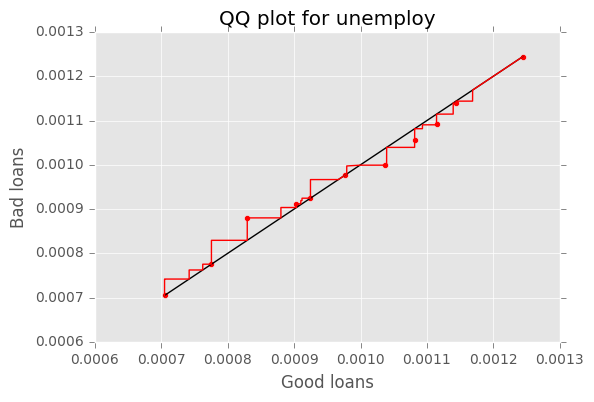

In [21]:
good_bad_quantile_plot(data, 'unemploy')

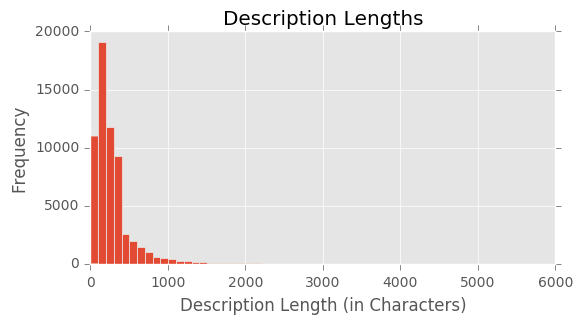

In [22]:
# visualize description lengths in characters
fig = plt.figure(figsize = (6, 3))

description_flags = data["description"].notnull()
description_lengths = data['desc_len'][description_flags]

ax1 = fig.add_subplot(111)
ax1.hist(description_lengths, bins = 50)
ax1.set_title("Description Lengths")
ax1.set_xlabel("Description Length (in Characters)")
ax1.set_ylabel("Frequency")

plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

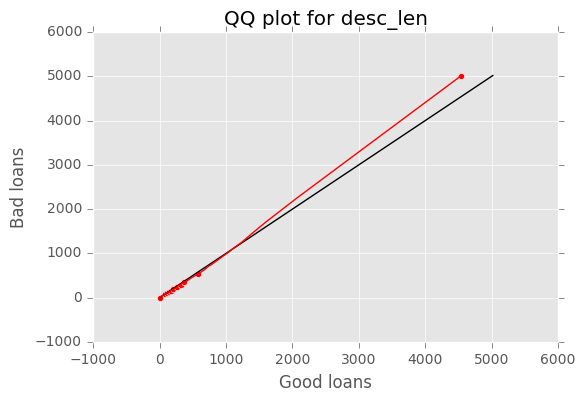

In [23]:
data_desc = data[description_flags]
good_bad_quantile_plot(data_desc, 'desc_len')

In [24]:
description_lengths_df = pd.DataFrame(description_lengths)
description_lengths_df.columns = ["description_length_chars"]
description_lengths_df.describe()

,description_length_chars
count,61407.000000
mean,291.780644
std,314.126188
min,1.000000
25%,120.000000
50%,206.000000
75%,342.000000
max,5016.000000


In [25]:
# Are descriptions correlated with inclusion of descriptions?
data_corr = pd.concat((data["loan_status"], description_flags), axis = 1)
corr_matrix = np.corrcoef(data_corr.T)

print
print "Loan status is not correlated with the inclusion of descriptions:\n"
print corr_matrix
print


Loan status is not correlated with the inclusion of descriptions:

[[ 1.         -0.01813025]
 [-0.01813025  1.        ]]



### Text Analysis

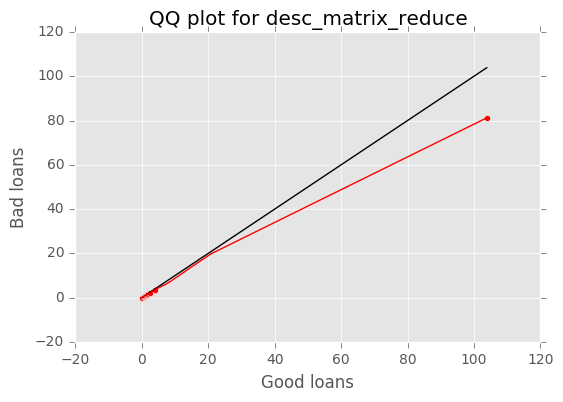

In [26]:
good_bad_quantile_plot(data_nlp, 'desc_matrix_reduce')

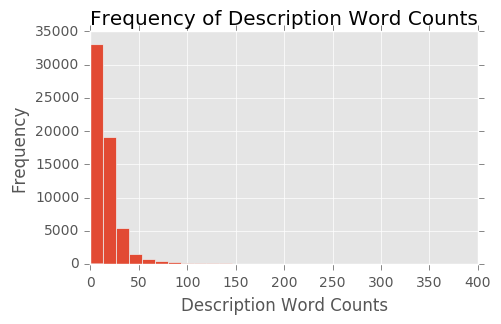

In [27]:
# plot histogram of word counts by description
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['desc_word_count'].values, bins = 30)
ax.set_title("Frequency of Description Word Counts")
ax.set_xlabel("Description Word Counts")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

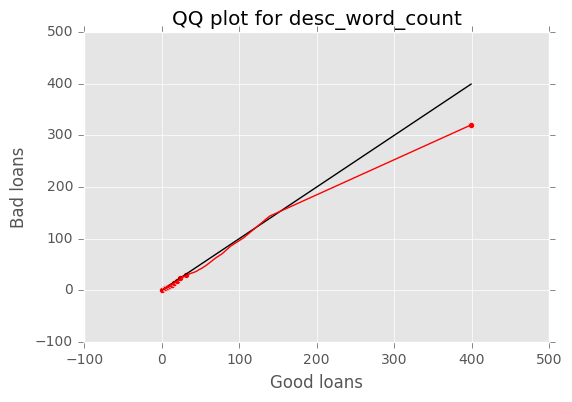

In [28]:
good_bad_quantile_plot(data_nlp, "desc_word_count")

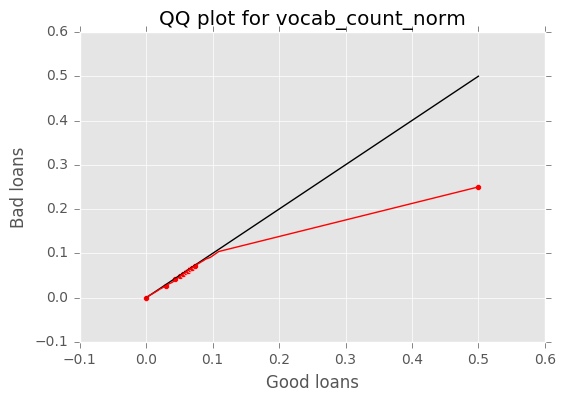

In [29]:
good_bad_quantile_plot(data_nlp, "vocab_count_norm")

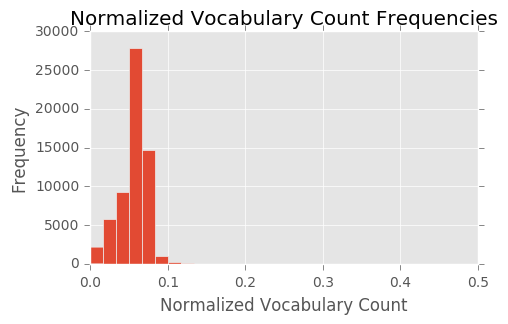

In [30]:
# plot histogram of vocabulary richness
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['vocab_count_norm'], bins = 30)
ax.set_title("Normalized Vocabulary Count Frequencies")
ax.set_xlabel("Normalized Vocabulary Count")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

In [31]:
print desc_matrix.shape

(61407, 14082)


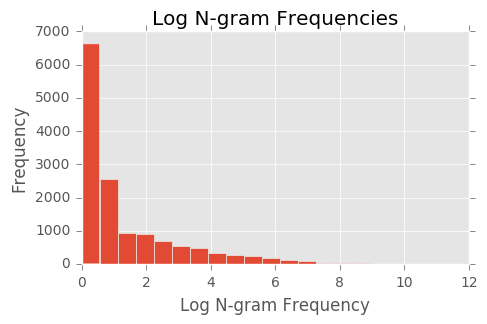

In [32]:
ngram_counts = np.log(desc_matrix.sum(axis = 0))

# plot histogram of n-gram frequency
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(ngram_counts.transpose(), bins = 20)
ax.set_title("Log N-gram Frequencies")
ax.set_xlabel("Log N-gram Frequency")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

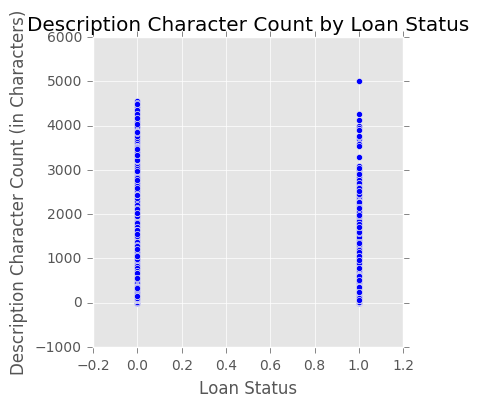

In [33]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['desc_len'])
ax1.set_title("Description Character Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Description Character Count (in Characters)")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

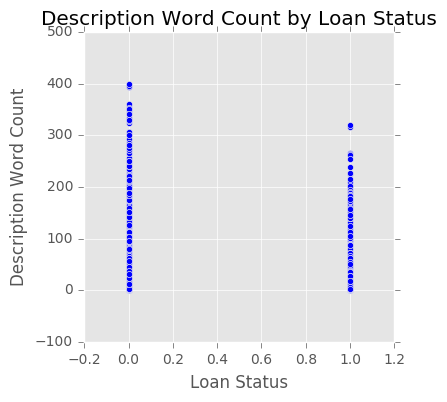

In [34]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['desc_word_count'])
ax1.set_title("Description Word Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Description Word Count")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

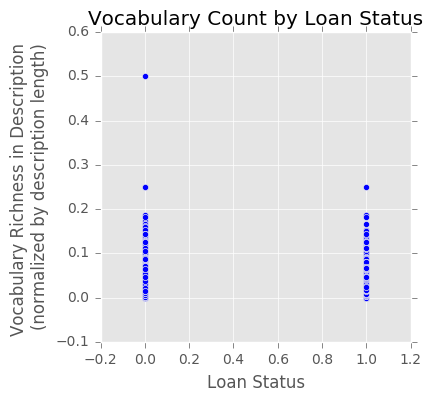

In [35]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['vocab_count_norm'])
ax1.set_title("Vocabulary Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Vocabulary Richness in Description \n(normalized by description length)")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

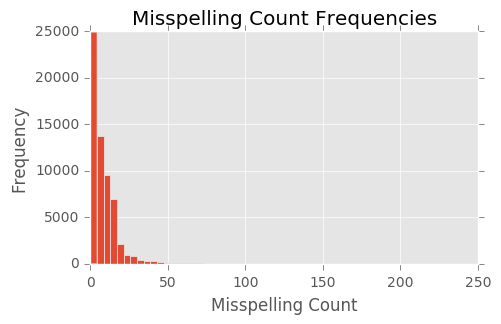

In [36]:
# plot histogram of misspelling counts
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['misspell_count'], bins = 50)
ax.set_title("Misspelling Count Frequencies")
ax.set_xlabel("Misspelling Count")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

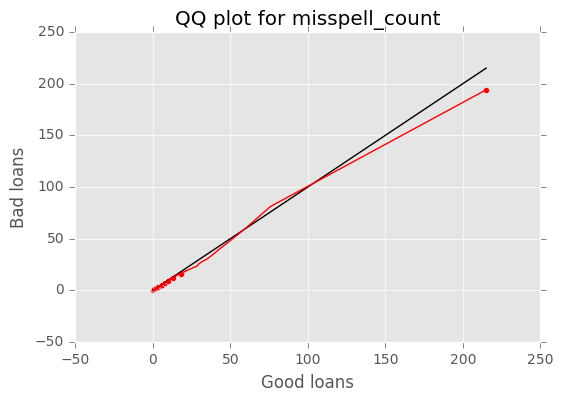

In [37]:
good_bad_quantile_plot(data_nlp, "misspell_count")

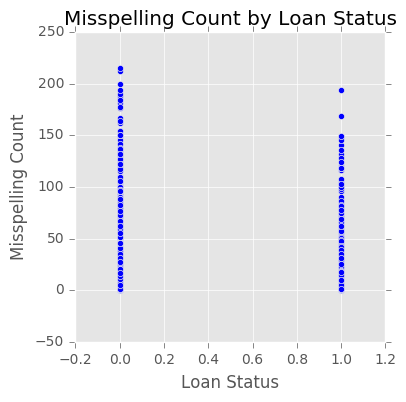

In [38]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['misspell_count'])
ax1.set_title("Misspelling Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Misspelling Count")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

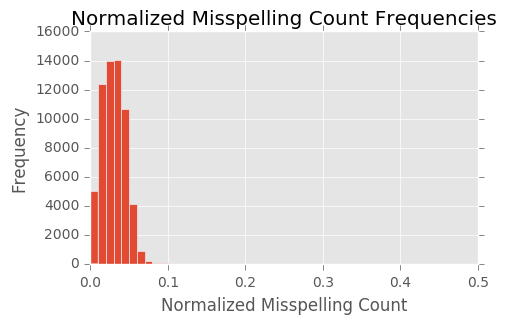

In [39]:
# plot histogram of normalized misspelling counts
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['misspell_count_norm'], bins = 50)
ax.set_title("Normalized Misspelling Count Frequencies")
ax.set_xlabel("Normalized Misspelling Count")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

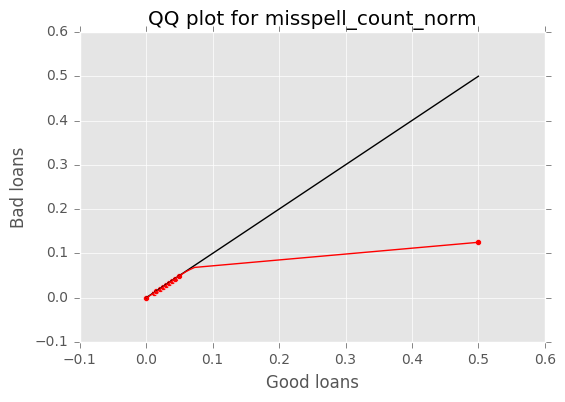

In [40]:
good_bad_quantile_plot(data_nlp, "misspell_count_norm")

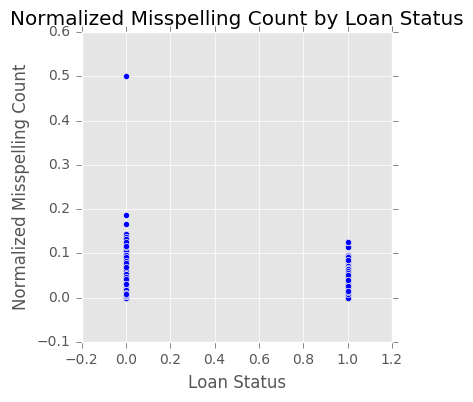

In [41]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['misspell_count_norm'])
ax1.set_title("Normalized Misspelling Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Normalized Misspelling Count")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

### Plot NLP Features

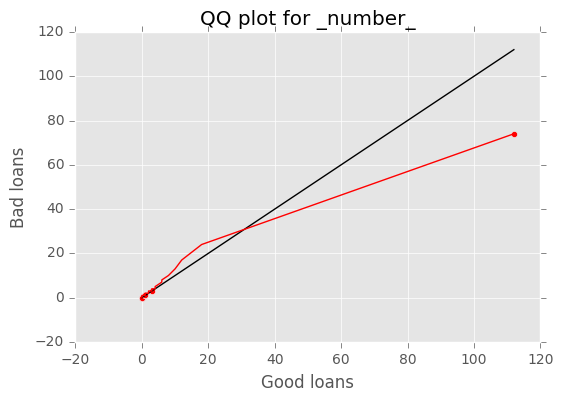

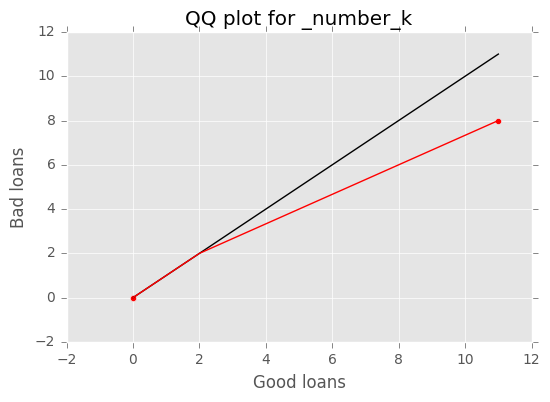

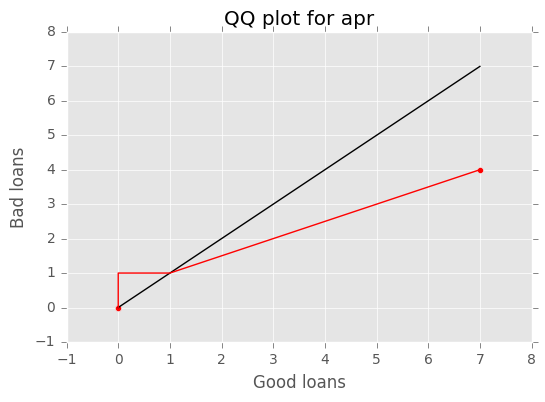

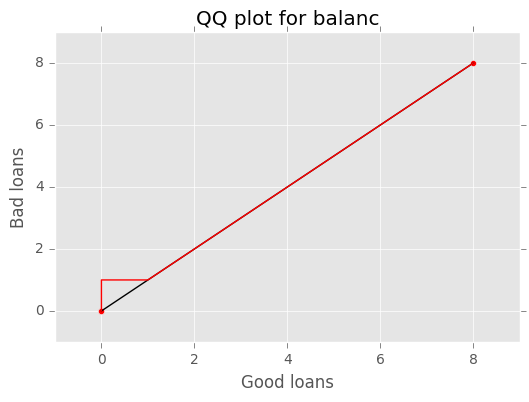

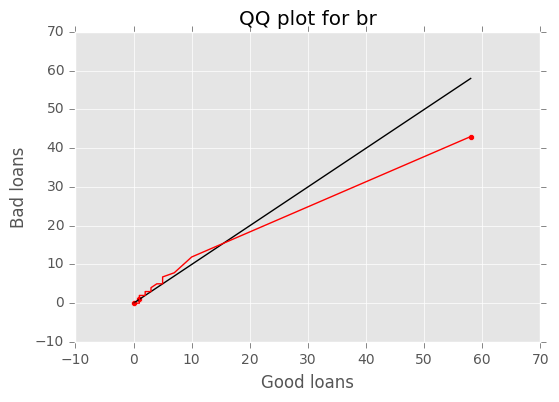

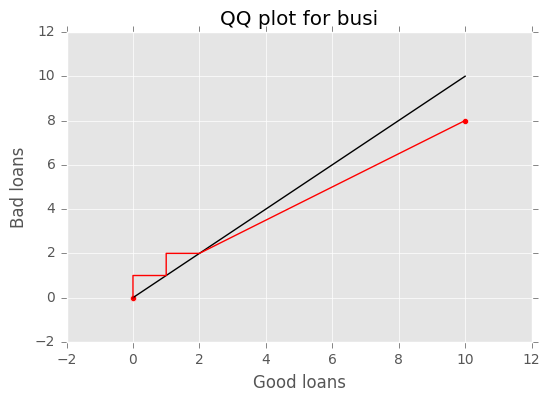

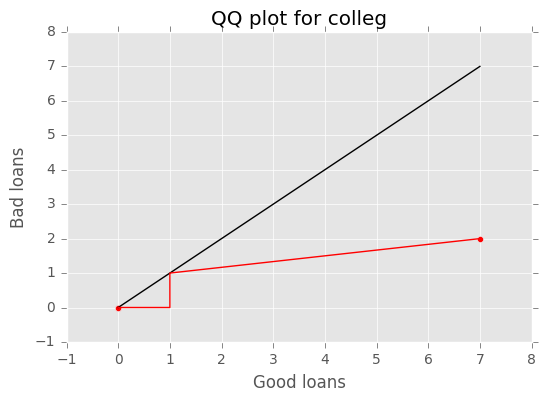

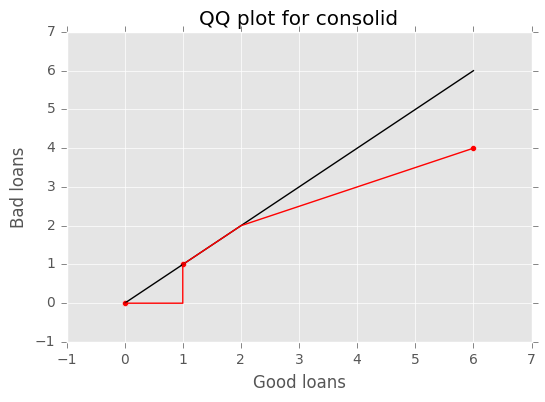

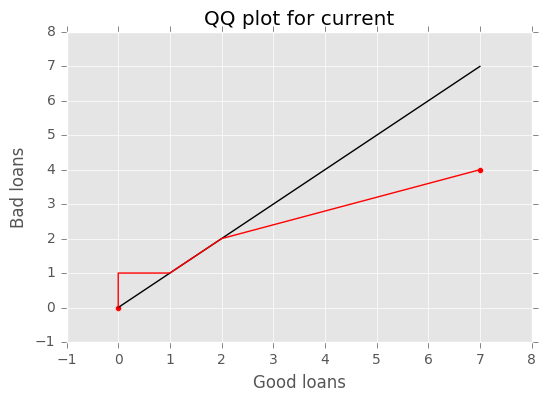

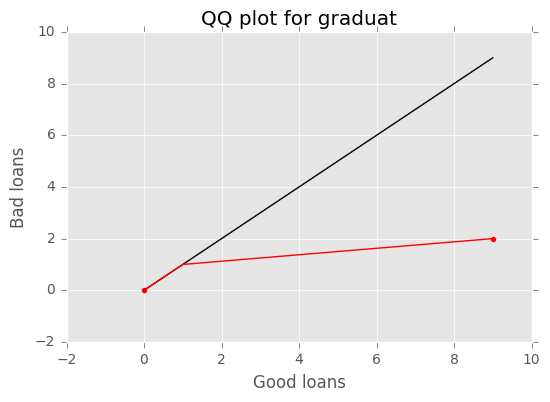

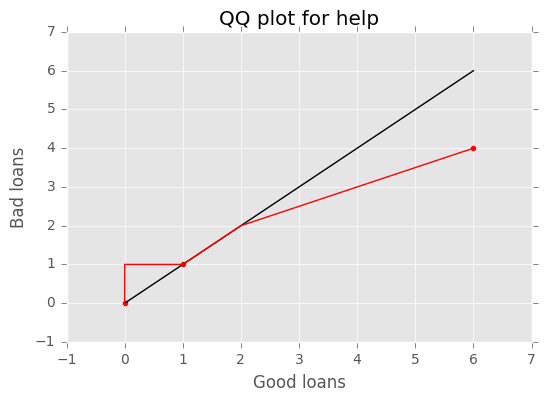

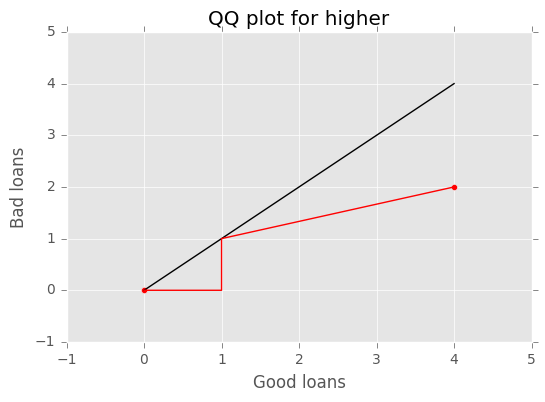

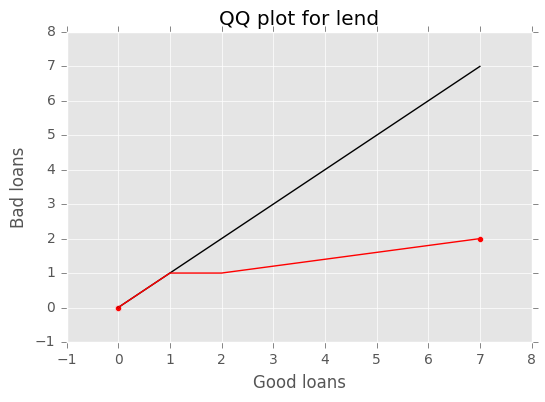

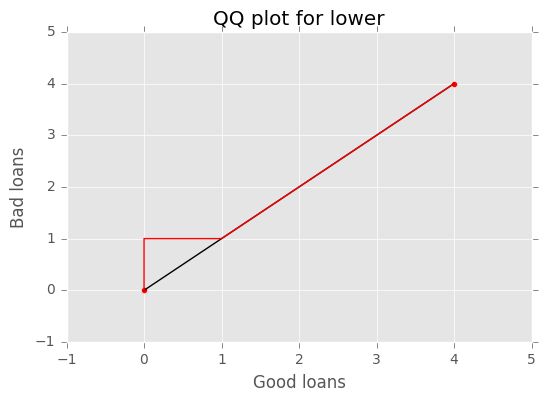

In [43]:
count_cols_qq_data = pd.concat((data_nlp['loan_status'], count_cols_df), axis = 1)
for index in range(1, count_cols_bool.shape[1] / 2):
    good_bad_quantile_plot(count_cols_qq_data, count_cols_qq_data.columns[index])

## Step 3: Model Data

In [44]:
# define model types
log_reg = 2
lda = 3
qda = 4
knn = 5
rf = 6
boost = 7
svm = 8

In [45]:
# function to return name of model type
def get_model_name(model_type):
    if model_type == log_reg:
        model_name = "logistic regression"
    elif model_type == lda:
        model_name = "LDA"
    elif model_type == qda:
        model_name = "QDA"
    elif model_type == knn:
        model_name = "KNN"
    elif model_type == rf:
        model_name = "random forests"
    elif model_type == boost:
        model_name = "boost"
    elif model_type == svm:
        model_name = "SVM"
    else:
        model_name = ""
        
    return model_name

In [46]:
# function to return unfitted model of given type
def get_model_instance(model_type, y):
    default_ratio = (y == True).sum() / float(len(y))
    priors = (default_ratio, 1.0 - default_ratio)
    
    if model_type == log_reg:
         model_instance = Log_Reg(C = 10 ** -4, class_weight = 'balanced',
                                 penalty = 'l2', solver = 'liblinear', fit_intercept = True)
    elif model_type == lda:
        model_instance = LDA(priors = priors)
    elif model_type == qda:
        model_instance = QDA(reg_param = 0.0001)
    elif model_type == knn:
        model_instance = KNN(n_neighbors = 5)
    elif model_type == rf:
        model_instance = RFC(n_estimators = 10, class_weight = 'balanced',
                            max_features = 'auto', max_depth = 20)
    elif model_type == boost:
        model_instance = Boost(n_estimators = 100, learning_rate = 0.4)
    elif model_type == svm:
        model_instance = SVC(C = 100, kernel = 'poly', degree = 2, class_weight = 'balanced',
                            shrinking = True)
    else:
        model_instance = None
        
    return model_instance

In [47]:
# function to fit and score one model of given type
def fit_and_score_one_model(x, y, model_type):
    n = x.shape[0]

    train_score_accum = 0
    test_score_accum = 0
    cm_accum = np.zeros((2, 2))
    f1_accum = 0
    num_iters = 3
    for i in range(num_iters):
        mask = np.random.rand(n) < 0.8
     
        x_train = x[mask, :]
        x_test = x[~mask, :]
        
        y_train = y.iloc[mask]
        y_test = y.iloc[~mask]
  
        model = get_model_instance(model_type, y_train)
        model.fit(x_train, y_train)
        y_predict = model.predict(x_test)
        cm_accum += confusion_matrix(y_test, y_predict)
        train_score_accum += model.score(x_train, y_train)
        test_score_accum += model.score(x_test, y_test)
        f1_accum += f1_score(y_test, y_predict, pos_label = 1)

    # calculate accuracy
    train_score = train_score_accum / float(num_iters)
    test_score = test_score_accum / float(num_iters)
    f1_result = f1_accum / float(num_iters)

    # compute confusion matrix
    cm = cm_accum / float(num_iters)
    #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_df = pd.DataFrame(cm, columns = ["Predicted_bad", "Predicted_good"])
    row_labels = pd.DataFrame(["Actual_bad", "Actual_good"])
    cm_df = pd.concat((row_labels, cm_df), axis = 1)
    
    # output results
    model_name = get_model_name(model_type)
    print "Accuracy with " + model_name + ":"
    print "\tTraining:", round(train_score, 4)
    print "\tTesting:", round(test_score, 4)
    print
    print "Confusion Matrix:"
    display(cm_df)
    print "F1 score = ", f1_result

### NLP

In [48]:
# KNN 
# fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], knn)

In [49]:
# logistic regression
fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], log_reg)

Accuracy with logistic regression:
	Training: 0.4041
	Testing: 0.3995

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,3529.0,6633.333333
1,Actual_good,738.0,1381.000000


F1 score =  0.271140659867


In [50]:
# logistic regression 
fit_and_score_one_model(data_nlp[['misspell_count', 'desc_len']].values, 
                        data_nlp['loan_status'], rf)

Accuracy with random forests:
	Training: 0.6814
	Testing: 0.6031

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,6639.666667,3579.333333
1,Actual_good,1296.666667,770.000000


F1 score =  0.239867649831


In [51]:
# nlp_plus = np.concatenate((count_cols_bool.toarray(), data_nlp[['loan_amount']]), axis = 1)
# fit_and_score_one_model(nlp_plus, data_nlp['loan_status'], log_reg)

In [52]:
# LDA
fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], lda)

Accuracy with LDA:
	Training: 0.1715
	Testing: 0.1735

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,0.0,10228.666667
1,Actual_good,0.0,2147.000000


F1 score =  0.295657881301


In [53]:
# # use description column with QDA to predict defaults and score accuracy
fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], qda)

Accuracy with QDA:
	Training: 0.7933
	Testing: 0.787

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,9507.666667,624.333333
1,Actual_good,1985.666667,133.666667


F1 score =  0.0928111978376


In [54]:
# random forests 
fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], rf)

Accuracy with random forests:
	Training: 0.6533
	Testing: 0.5895

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,6501.000000,3750.333333
1,Actual_good,1317.666667,772.000000


F1 score =  0.229350356173


In [55]:
# SVM
# fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], svm)

In [56]:
# boosting
# fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], boost)

In [57]:
fit_and_score_one_model(desc_matrix, data_nlp['loan_status'], log_reg)

Accuracy with logistic regression:
	Training: 0.6
	Testing: 0.5845

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,6409.333333,3806.000000
1,Actual_good,1304.666667,782.666667


F1 score =  0.234402291805


In [58]:
fit_and_score_one_model(desc_matrix, data_nlp['loan_status'], rf)

Accuracy with random forests:
	Training: 0.3995
	Testing: 0.3736

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,3075.666667,7035.666667
1,Actual_good,624.000000,1493.666667


F1 score =  0.280559301919


### Baseline Models

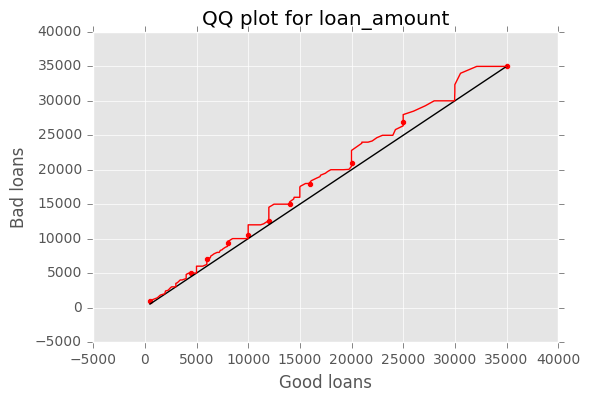

In [59]:
good_bad_quantile_plot(data, 'loan_amount')

In [60]:
# logistic regression
fit_and_score_one_model(data[['loan_amount']].values, data['loan_status'], log_reg)

Accuracy with logistic regression:
	Training: 0.481
	Testing: 0.4805

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,12912.333333,15625.666667
1,Actual_good,2505.666667,3855.333333


F1 score =  0.298364940862


In [61]:
# random_forests
fit_and_score_one_model(data[['loan_amount']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.6744
	Testing: 0.6643

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,20774.000000,7797.333333
1,Actual_good,3929.333333,2433.333333


F1 score =  0.293293769088


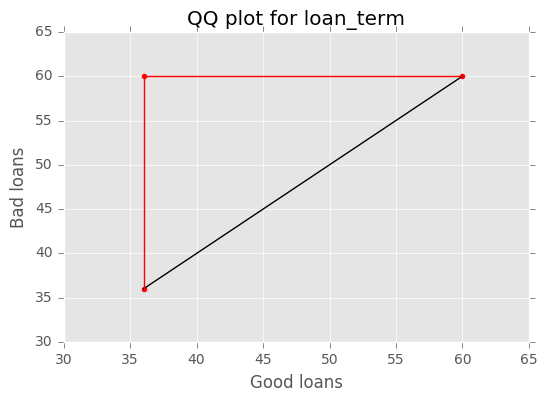

In [62]:
good_bad_quantile_plot(data, 'loan_term')

In [63]:
fit_and_score_one_model(data[['loan_term']].values, data['loan_status'], log_reg)

Accuracy with logistic regression:
	Training: 0.1814
	Testing: 0.1811

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,0.0,28446.333333
1,Actual_good,0.0,6291.333333


F1 score =  0.306673656828


In [64]:
# random_forests
fit_and_score_one_model(data[['loan_term']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.7274
	Testing: 0.7251

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,22909.333333,5392.666667
1,Actual_good,4141.333333,2236.000000


F1 score =  0.319296796764


In [65]:
# SVM
# fit_and_score_one_model(data[['loan_term']].values, data['loan_status'], svm)

In [66]:
# random_forests
fit_and_score_one_model(data[['loan_amount', 'dti', 'revol_util', 'rir', 
                             'annual_income', 'loan_term']].values, 
                        data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.9345
	Testing: 0.7663

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,25301.666667,3150.0
1,Actual_good,4978.000000,1345.0


F1 score =  0.248677779995


In [67]:
# SVM
# fit_and_score_one_model(data[['loan_amount']].values, data['loan_status'], svm)

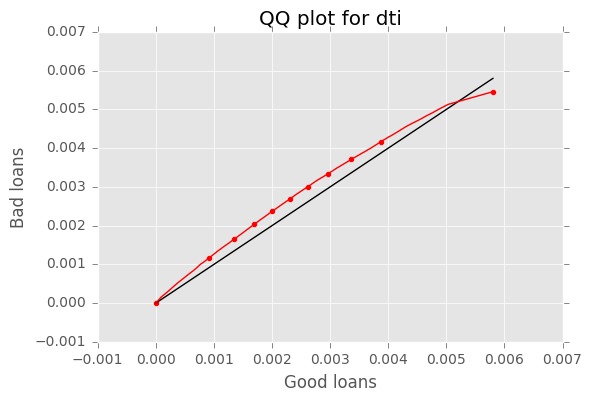

In [68]:
good_bad_quantile_plot(data, 'dti')

In [69]:
# random_forests
fit_and_score_one_model(data[['dti']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.6619
	Testing: 0.613

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,18665.000000,9769.666667
1,Actual_good,3662.333333,2616.333333


F1 score =  0.280310020041


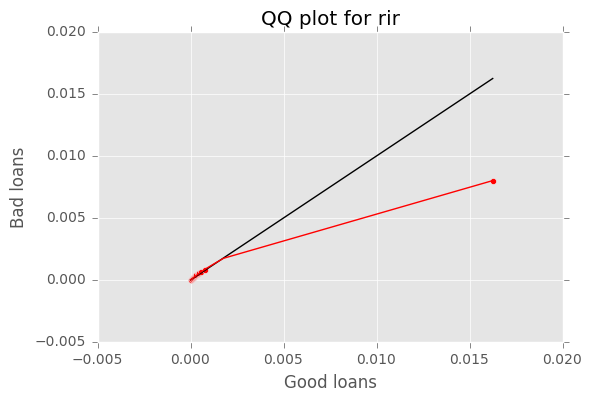

In [70]:
good_bad_quantile_plot(data, 'rir')

In [71]:
# random_forests
fit_and_score_one_model(data[['dti']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.6611
	Testing: 0.6099

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,18548.333333,9897.333333
1,Actual_good,3653.666667,2636.333333


F1 score =  0.280138822331


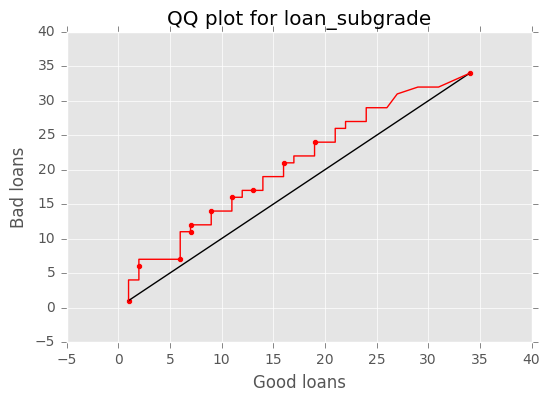

In [72]:
good_bad_quantile_plot(data, 'loan_subgrade')

In [73]:
# random_forests
fit_and_score_one_model(data[['loan_subgrade']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.5598
	Testing: 0.558

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,14832.666667,13659.666667
1,Actual_good,1716.000000,4579.000000


F1 score =  0.373298501266


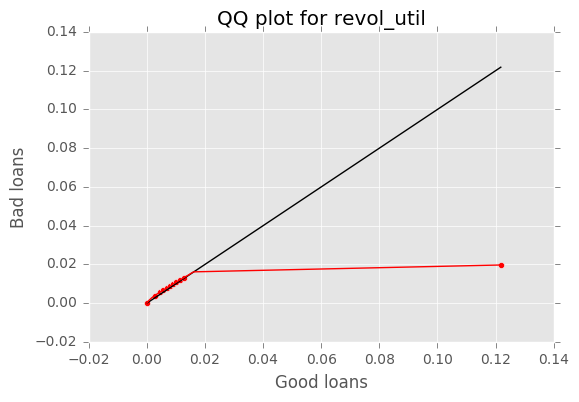

In [74]:
good_bad_quantile_plot(data, 'revol_util')

In [75]:
# random_forests
fit_and_score_one_model(data[['revol_util']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.6137
	Testing: 0.5579

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,16184.666667,12170.333333
1,Actual_good,3173.333333,3180.666667


F1 score =  0.293055819933


### Stacking

In [76]:
### extract predictors and response
def extract_predictors_response(x, y):
    mask = np.random.rand(x.shape[0]) < 0.8

    x_train = x[mask, :]
    x_test = x[~mask, :]

    y_train = y.values[mask]
    y_test = y.values[~mask]
    
    return x_train, y_train, x_test, y_test

In [77]:
# function to create model stack
def create_model_stack(x, y):
    model_stack = []

    # logistic regression
    model = get_model_instance(log_reg, y)
    model.fit(x, y)
    model_stack.append(model)

#     # QDA
#     model = get_model_instance(qda, y)
#     model.fit(x, y)
#     model_stack.append(model)

#     # KNN
#     model = get_model_instance(knn, y)
#     model.fit(x, y)
#     model_stack.append(model)

    # random forests
    model = get_model_instance(rf, y)
    model.fit(x, y)
    model_stack.append(model)

    # # boosting
    # model = get_model_instance(boost, y)
    # model.fit(x, y)
    # model_stack.append(model)

#     # SVM
#     model = get_model_instance(svm, y)
#     model.fit(x, y)
#     model_stack.append(model)
    
    return model_stack

In [78]:
# function to fit and score a stacking ensemble
def fit_score_stacking(models, x_train, y_train, x_test, y_test, combiner, combiner_name):
    n_train = x_train.shape[0]
    n_test = x_test.shape[0]
    num_models = len(models)
    
    # create variables to hold predictions
    y_train_stack = np.zeros((n_train, num_models))
    y_test_stack = np.zeros((n_test, num_models))
    y_predict = np.zeros(n_test)

    # predict with each model on training and testing data
    for index in range(num_models):
        model = models[index]
        y_train_stack[:, index] = model.predict(x_train)
        y_test_stack[:, index] = model.predict(x_test)

    # predict with ensemble
    combiner.fit(y_train_stack, y_train)
    y_predict = combiner.predict(y_test_stack)
    
    # score with ensemble
    score = combiner.score(y_test_stack, y_test)
    cm = confusion_matrix(y_test, y_predict)
    f1_result = f1_score(y_test, y_predict, pos_label = 1)
    
    # format confusion matrix
    cm_df = pd.DataFrame(cm, columns = ["Predicted_bad", "Predicted_good"])
    row_labels = pd.DataFrame(["Actual_bad", "Actual_good"])
    cm_df = pd.concat((row_labels, cm_df), axis = 1)

    return score, cm_df, f1_result

In [79]:
# fit and score a stacked model for given predictors and response
def try_one_stacked_model(x, y, combiner_type, combiner_name):

    x_train, y_train, x_test, y_test = extract_predictors_response(x, y)

    model_stack = create_model_stack(x_train, y_train)

    combiner = get_model_instance(combiner_type, y_train)

    score, cm_df, f1_result = fit_score_stacking(model_stack, x_train, y_train, 
                                                 x_test, y_test, combiner, combiner_name)

    print
    print "Accuracy with stacking by " + combiner_name + " = " + str(round(score, 4))
    print
    print "Confusion Matrix"
    display(cm_df)
    print
    print "F1 score with stacking by " + combiner_name + " = " + str(round(f1_result, 4))

In [80]:
# fit and score a stacked-model ensemble using NLP features
try_one_stacked_model(count_cols_bool, data_nlp['loan_status'], rf, "random forests")


Accuracy with stacking by random forests = 0.5293

Confusion Matrix


,0,Predicted_bad,Predicted_good
0,Actual_bad,5617,4661
1,Actual_good,1175,946



F1 score with stacking by random forests = 0.2448


In [81]:
# fit and score a stacked-model ensemble using loan amount
try_one_stacked_model(data['loan_amount'].reshape(-1, 1), data['loan_status'], 
                      rf, "random forests")


Accuracy with stacking by random forests = 0.6462

Confusion Matrix


,0,Predicted_bad,Predicted_good
0,Actual_bad,19786,8447
1,Actual_good,3749,2494



F1 score with stacking by random forests = 0.2903


In [82]:
try_one_stacked_model(desc_matrix, data_nlp['loan_status'], rf, "random forests")


Accuracy with stacking by random forests = 0.3974

Confusion Matrix


,0,Predicted_bad,Predicted_good
0,Actual_bad,3491,6666
1,Actual_good,719,1379



F1 score with stacking by random forests = 0.2719


In [83]:
nlp_base = np.concatenate((count_cols_bool, 
                           data_nlp[['loan_amount', 'annual_income', 'rir',
                                    'revol_util', 'dti', 'loan_term']]), axis = 1)
try_one_stacked_model(nlp_base, data_nlp['loan_status'], log_reg, "logistic regression")


Accuracy with stacking by logistic regression = 0.7825

Confusion Matrix


,0,Predicted_bad,Predicted_good
0,Actual_bad,9273,1014
1,Actual_good,1686,443



F1 score with stacking by logistic regression = 0.2471
